In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Flatten, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [2]:
# starting with row 199 as it is the first with 200 vol data and all feature columns are real values
data = pd.read_csv('/data/workspace_files/ten_feature_set.csv').iloc[199:,:]
data = data.set_index('Date')
data.describe()

,Weighted Volume Price,200 hour moving average,50 hour moving average,bollinger_up_7hr,bollinger_down_7hr,RSI,200 hour volatility,7 hour return,6 hour return,5 hour return
count,62516.000000,62516.000000,62516.000000,62516.000000,62516.000000,62516.000000,62516.000000,62516.000000,62516.000000,62516.000000
mean,8788.475526,8714.887610,8770.067200,8928.570340,8643.909917,49.645156,388.630033,0.000733,0.000631,0.000530
std,13087.279313,12978.880489,13059.430221,13310.142284,12860.563813,7.599729,688.913055,0.022032,0.020543,0.018966
min,162.039355,208.160163,200.171171,191.180602,156.863748,0.000000,1.241665,-0.305045,-0.310109,-0.273110
25%,525.000000,519.864050,521.984500,535.890066,524.790000,50.031364,14.183913,-0.006329,-0.005750,-0.005240
50%,4897.311471,4695.670280,4888.332722,5021.764672,4790.800345,50.075449,131.981442,0.000411,0.000319,0.000257
75%,9489.017500,9408.018850,9468.619000,9582.327648,9376.208591,50.159294,397.965679,0.008182,0.007347,0.006530
max,64626.050000,61305.967350,63199.671800,64982.191986,63588.549156,99.009901,5135.464347,0.286060,0.313425,0.265228


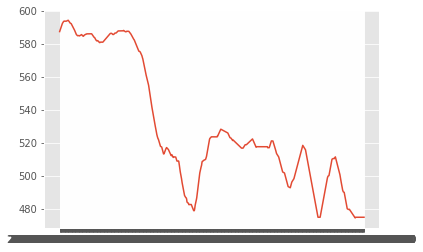

In [3]:
plt.plot(data.iloc[0:1000, 2])

In [4]:
X_data = data.copy()

target = np.zeros((X_data.shape[0],7))
for i in range(7):
    vals = (X_data['Weighted Volume Price'].shift(-(i+1))/X_data['Weighted Volume Price'] - 1).iloc[:-(i+1)]
    target[:vals.shape[0], i] = vals
X_data = X_data.iloc[:-7]
target = target[:-7,:]
print(target.shape)
print(X_data.shape)

# checking the values line up
assert (target[5790,0] == (X_data.iloc[5791,0]/X_data.iloc[5790,0]-1))
assert (target[5790,1] == (X_data.iloc[5792,0]/X_data.iloc[5790,0]-1))
assert (target[5790,2] == (X_data.iloc[5793,0]/X_data.iloc[5790,0]-1))
assert (target[5790,3] == (X_data.iloc[5794,0]/X_data.iloc[5790,0]-1))
assert (target[5790,4] == (X_data.iloc[5795,0]/X_data.iloc[5790,0]-1))
assert (target[5790,5] == (X_data.iloc[5796,0]/X_data.iloc[5790,0]-1))
assert (target[5790,6] == (X_data.iloc[5797,0]/X_data.iloc[5790,0]-1))

target = pd.DataFrame(data=target, index=X_data.index)
assert(target.index == X_data.index).all()

(62509, 7)
(62509, 10)


In [5]:
# For RNNs
def get_training_data(data):
    return data.loc[:'2019-02-01']

def get_validation_data(data):
    return data.loc['2019-02-01':'2019-08-01']

def get_test_data(data):
    return data.loc['2019-08-01':'2021-06-30']


def return_sequenced_data(data, target, sequence_length=48):
    D = data.shape[1]

    # For training data
    train = get_training_data(data)
    train_target = get_training_data(target).values
    N = len(train) - sequence_length

    X_train = np.zeros((N, sequence_length, D))
    Y_train = np.zeros((N, 7))
    scaler = StandardScaler()
    train = scaler.fit_transform(train)

    for t in range(N):
        X_train[t, :, :] = train[t:t+sequence_length]
        Y_train[t, :] = train_target[t]
    
    # For validation data
    valid = get_validation_data(data)
    N = len(valid) - sequence_length
    X_valid = np.zeros((N, sequence_length, D))
    Y_valid = np.zeros((N,7))
    scaler = StandardScaler()
    valid = scaler.fit_transform(valid)
    valid_target = get_validation_data(target).values
    
    for t in range(N - sequence_length):
        X_valid[t, :, :] = valid[t:t+sequence_length]
        Y_valid[t, :] = valid_target[t]

    test = get_test_data(data)
    test_target = get_test_data(target).values
    N = len(test) - sequence_length
    scaler = StandardScaler()
    test = scaler.fit_transform(test)
    X_test = np.zeros((N, sequence_length, D))
    Y_test = np.zeros((N,7))
    
    for t in range(N - sequence_length):
        X_test[t, :, :] = test[t:t+sequence_length]
        Y_test[t] = test_target[t]
        
        
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = return_sequenced_data(X_data, target)

In [6]:
# LSTM

epochs = 40
T = 48
D = X_train.shape[2]


i = Input(shape=(T, D))
x = LSTM(100)(i)
x = Dense(7)(x)
model = Model(i, x)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=Adam(learning_rate=0.001))
r = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/40
1233/1233 [==============================] - 8s 4ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 2/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 3/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 4/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 5/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 6/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 7/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 8/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 9/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 10/40
1233/1233 [==============================] - 4s 3ms/step - loss: 0.004

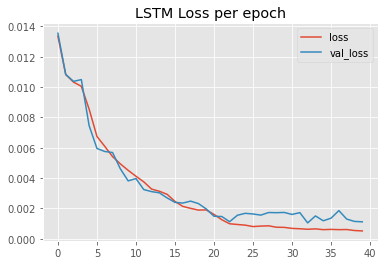

In [7]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('LSTM Loss per epoch')
plt.legend()

model output shape:  (4296, 7)
training data shape:  (4296,)
shape of targets:  (4296,)


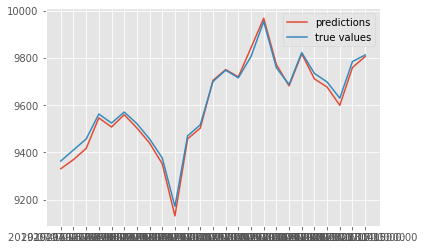

In [8]:
# graphing predictions using validation set

predictions = model.predict(X_valid)[:4500]
true_values = get_validation_data(X_data)[:predictions.shape[0]]['Weighted Volume Price']
print('model output shape: ', predictions.shape)
print('training data shape: ', true_values.shape)

predictions = ((1+predictions[:,6]) * true_values)

# shift true values back to line them up with predictions
true_values = true_values.shift(-7)


print('shape of targets: ', true_values.shape)
plt.plot(predictions[3975:4000], label='predictions')
plt.plot(true_values[3975:4000], label='true values')
plt.legend()

In [9]:
# testing on validation set

predictions = model.predict(X_valid)
true_values = get_validation_data(X_data)[:predictions.shape[0]]['Weighted Volume Price']
print('predictions shape: ', predictions.shape)
print('true values shape: ', true_values.shape)
price_predictions = np.zeros((predictions.shape[0], 7))
true_values_ahead = np.zeros((predictions.shape[0], 7))
for i in range(7):
    price_predictions[:,i] = (1+predictions[:,i]) * true_values
    true_values_ahead[:,i] = true_values.shift(-(i+1))

# removing the last seven rows since they will be nan
price_predictions = price_predictions[:-7,:]
true_values_ahead = true_values_ahead[:-7,:]

print(price_predictions.shape)
print(true_values_ahead.shape)

total_predictions = price_predictions.shape[0] * price_predictions.shape[1]
mae = np.abs(true_values_ahead - price_predictions).sum()/total_predictions
print('mae: ', mae)
rmse = np.sqrt(np.sum((true_values_ahead - price_predictions)**2)/total_predictions)
print('rmse: ', rmse)

predictions shape:  (4296, 7)
true values shape:  (4296,)
(4289, 7)
(4289, 7)
mae:  8.680547541155278
rmse:  14.90812646811481


In [10]:
# testing on test set

predictions = model.predict(X_test)
true_values = get_test_data(X_data)[:predictions.shape[0]]['Weighted Volume Price']
print('predictions shape: ', predictions.shape)
print('true values shape: ', true_values.shape)
price_predictions = np.zeros((predictions.shape[0], 7))
true_values_ahead = np.zeros((predictions.shape[0], 7))
for i in range(7):
    price_predictions[:,i] = (1+predictions[:,i]) * true_values
    true_values_ahead[:,i] = true_values.shift(-(i+1))

# removing the last seven rows since they will be nan
price_predictions = price_predictions[:-7,:]
true_values_ahead = true_values_ahead[:-7,:]

print(price_predictions.shape)
print(true_values_ahead.shape)

total_predictions = price_predictions.shape[0] * price_predictions.shape[1]
mae = np.abs(true_values_ahead - price_predictions).sum()/total_predictions
print('mae: ', mae)
rmse = np.sqrt(np.sum((true_values_ahead - price_predictions)**2)/total_predictions)
print('rmse: ', rmse)

predictions shape:  (16725, 7)
true values shape:  (16725,)
(16718, 7)
(16718, 7)
mae:  14.571782068716452
rmse:  44.490357818501785


In [11]:
# GRU
epochs = 50
T = 48
D = X_train.shape[2]


i = Input(shape=(T, D))
x = GRU(100)(i)
x = Dense(7)(x)
model = Model(i, x)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=Adam(learning_rate=0.00075))
r = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/50
1233/1233 [==============================] - 7s 4ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 2/50
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 3/50
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0112 - val_loss: 0.0119
Epoch 4/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 5/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 6/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 7/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 8/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 9/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 10/50
1233/1233 [==============================] - 4s 3ms/step - loss: 0.008

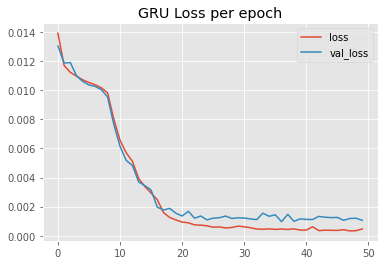

In [15]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('GRU Loss per epoch')
plt.legend()

model output shape:  (4296, 7)
training data shape:  (4296,)
shape of targets:  (4296,)


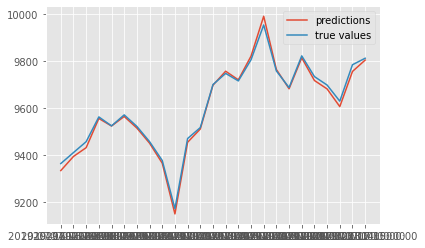

In [16]:
predictions = model.predict(X_valid)[:4500]
true_values = get_validation_data(X_data)[:predictions.shape[0]]['Weighted Volume Price']
print('model output shape: ', predictions.shape)
print('training data shape: ', true_values.shape)

predictions = ((1+predictions[:,6]) * true_values)

# shift true values back to line them up with predictions
true_values = true_values.shift(-7)


print('shape of targets: ', true_values.shape)
plt.plot(predictions[3975:4000], label='predictions')
plt.plot(true_values[3975:4000], label='true values')
plt.legend()

In [17]:
# testing on validation set
predictions = model.predict(X_valid)
true_values = get_validation_data(X_data)[:predictions.shape[0]]['Weighted Volume Price']
print('predictions shape: ', predictions.shape)
print('true values shape: ', true_values.shape)
price_predictions = np.zeros((predictions.shape[0], 7))
true_values_ahead = np.zeros((predictions.shape[0], 7))
for i in range(7):
    price_predictions[:,i] = (1+predictions[:,i]) * true_values
    true_values_ahead[:,i] = true_values.shift(-(i+1))

# removing the last seven rows since they will be nan for true_values_ahead
price_predictions = price_predictions[:-7,:]
true_values_ahead = true_values_ahead[:-7,:]

print(price_predictions.shape)
print(true_values_ahead.shape)

total_predictions = price_predictions.shape[0] * price_predictions.shape[1]
mae = np.abs(true_values_ahead - price_predictions).sum()/total_predictions
print('mae: ', mae)
rmse = np.sqrt(np.sum((true_values_ahead - price_predictions)**2)/total_predictions)
print('rmse: ', rmse)

predictions shape:  (4296, 7)
true values shape:  (4296,)
(4289, 7)
(4289, 7)
mae:  8.09429864538782
rmse:  13.597321092420396


In [18]:
# testing on test set
predictions = model.predict(X_test)
true_values = get_test_data(X_data)[:predictions.shape[0]]['Weighted Volume Price']
print('predictions shape: ', predictions.shape)
print('true values shape: ', true_values.shape)
price_predictions = np.zeros((predictions.shape[0], 7))
true_values_ahead = np.zeros((predictions.shape[0], 7))
for i in range(7):
    price_predictions[:,i] = (1+predictions[:,i]) * true_values
    true_values_ahead[:,i] = true_values.shift(-(i+1))

# removing the last seven rows since they will be nan for true_values_ahead
price_predictions = price_predictions[:-7,:]
true_values_ahead = true_values_ahead[:-7,:]

print(price_predictions.shape)
print(true_values_ahead.shape)

total_predictions = price_predictions.shape[0] * price_predictions.shape[1]
mae = np.abs(true_values_ahead - price_predictions).sum()/total_predictions
print('mae: ', mae)
rmse = np.sqrt(np.sum((true_values_ahead - price_predictions)**2)/total_predictions)
print('rmse: ', rmse)

predictions shape:  (16725, 7)
true values shape:  (16725,)
(16718, 7)
(16718, 7)
mae:  12.066409190761018
rmse:  40.11823286935319
